# TME Intelligence artificielle pour la robotique
# TD3 from Tianshou on LunarLanderContinuous-v2

* Étudiant 1: **CHAMOUN Joe 21312860**
* Étudiant 2: **GHENAIET Walid 21307720**


## Installations

In [ ]:
!pip uninstall gym tianshou -y

In [ ]:
!pip install gymnasium

In [ ]:
!pip install stable-baselines3

In [ ]:
!pip install swig

In [ ]:
!pip install box2d-py==2.3.8

In [ ]:
!pip install tianshou==0.5.0

## Training the model in the environment

In [7]:
import gymnasium as gym
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
import numpy as np
import cv2
from IPython import display
from IPython.display import Video
import matplotlib.pyplot as plt
from tianshou.policy import DDPGPolicy
from tianshou.data import Collector
from tianshou.env import DummyVectorEnv
from IPython.display import Video
import torch
from torch import nn
from tianshou.env import DummyVectorEnv
from tianshou.policy import TD3Policy
from tianshou.data import Collector, ReplayBuffer
from tianshou.data import VectorReplayBuffer
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import Actor, Critic
from tianshou.trainer import offpolicy_trainer

In [8]:
def create_environment(seed=None):
  env = gym.make('LunarLanderContinuous-v2')

  if seed is not None:
    env.reset(seed=seed)

  env = Monitor(env)
  env = DummyVecEnv([lambda: env])

  return env


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
def train_TD3(seed=None, num_episodes=75):
    env = create_environment(seed)

    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    train_envs = DummyVectorEnv([lambda: gym.make('LunarLanderContinuous-v2')] * 8)
    test_envs = DummyVectorEnv([lambda: gym.make('LunarLanderContinuous-v2')] * 1)

    if seed is not None:
        train_envs.seed(seed)
        test_envs.seed(seed)

    state_shape = env.observation_space.shape or env.observation_space.n
    action_shape = env.action_space.shape or env.action_space.n

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    net = Net(state_shape, hidden_sizes=[128, 128], device=device)

    actor = Actor(net, action_shape, max_action=env.action_space.high[0], device=device).to(device)

    critic1 = Critic(Net(state_shape, action_shape, hidden_sizes=[128, 128], concat=True, device=device)).to(device)
    critic2 = Critic(Net(state_shape, action_shape, hidden_sizes=[128, 128], concat=True, device=device)).to(device)

    actor_optim = torch.optim.Adam(actor.parameters(), lr=1e-3)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=1e-3)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=1e-3)

    policy = TD3Policy(
        actor,
        actor_optim,
        critic1,
        critic1_optim,
        critic2,
        critic2_optim,
        tau=0.005,
        gamma=0.99,
        exploration_noise=None,
        policy_noise=0.2,
        update_actor_freq=2,
        noise_clip=0.5,
        action_space=env.action_space
    )

    train_collector = Collector(policy, train_envs, VectorReplayBuffer(total_size=100000, buffer_num=8))
    test_collector = Collector(policy, test_envs, ReplayBuffer(10000))

    episode_rewards = []
    total_episodes = 0

    def collect_rewards(epoch, step):
        nonlocal total_episodes
        if total_episodes < num_episodes:
            last_rewards = train_collector.collect(n_episode=1)
            episode_rewards.append(np.mean(last_rewards["rews"]))
            total_episodes += 1
            if total_episodes >= num_episodes:
                return True  # Stop the training process


    result = offpolicy_trainer(
        policy,
        train_collector,
        test_collector,
        max_epoch=5,# 50
        step_per_epoch=1000,# 10000
        step_per_collect=5,
        episode_per_test=5,
        batch_size=128,
        update_per_step=0.1,
        test_in_train=False,
        train_fn=collect_rewards,
    )

    torch.save(policy.state_dict(), 'td3_lunarlander.pth')

    return episode_rewards


In [10]:
seed = 1
result = train_TD3(seed)


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
Epoch #1:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/tianshou/data/collector.py:236: UserWarning: n_step=5 is not a multiple of #env (8), which may cause extra transitions collected into the buffer.
  warnings.warn(
Epoch #1: 1001it [00:09, 110.32it/s, env_step=1000, len=124, loss/actor=2.032, loss/critic1=120.988, loss/critic2=121.155, n/ep=0, n/st=8, rew=-130.86]                          


Epoch #1: test_reward: -126.656650 ± 19.594770, best_reward: -126.656650 ± 19.594770 in #1


Epoch #2: 1001it [00:02, 471.55it/s, env_step=2000, len=56, loss/actor=2.222, loss/critic1=82.718, loss/critic2=81.699, n/ep=0, n/st=8, rew=-372.52]                          


Epoch #2: test_reward: -361.297162 ± 170.812044, best_reward: -126.656650 ± 19.594770 in #1


Epoch #3: 1001it [00:02, 473.80it/s, env_step=3000, len=132, loss/actor=2.936, loss/critic1=77.981, loss/critic2=78.498, n/ep=0, n/st=8, rew=-528.58]                          


Epoch #3: test_reward: -220.430473 ± 111.310543, best_reward: -126.656650 ± 19.594770 in #1


Epoch #4: 1001it [00:02, 492.05it/s, env_step=4000, len=79, loss/actor=4.059, loss/critic1=73.964, loss/critic2=74.567, n/ep=0, n/st=8, rew=-185.68]                          


Epoch #4: test_reward: -152.224744 ± 87.917301, best_reward: -126.656650 ± 19.594770 in #1


Epoch #5: 1001it [00:02, 367.86it/s, env_step=5000, len=94, loss/actor=4.506, loss/critic1=58.925, loss/critic2=59.002, n/ep=1, n/st=8, rew=-141.03]                          


Epoch #5: test_reward: -143.341028 ± 50.518558, best_reward: -126.656650 ± 19.594770 in #1


## Drawing the learning curve

In [11]:
rewards = [result]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


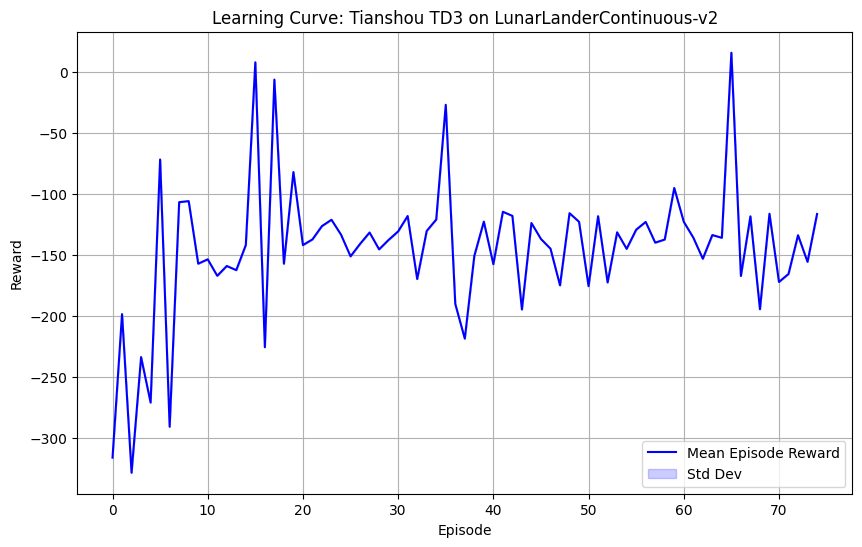

In [13]:

min_length = min(len(seed_rewards) for seed_rewards in rewards)

trimmed_rewards = [seed_rewards[:min_length] for seed_rewards in rewards]

rewards_array = np.array(trimmed_rewards)

mean_rewards = np.mean(rewards_array, axis=0)
std_rewards = np.std(rewards_array, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean_rewards, label='Mean Episode Reward', color='b')
plt.fill_between(range(len(mean_rewards)),
                 mean_rewards - std_rewards,
                 mean_rewards + std_rewards,
                 color='b', alpha=0.2, label='Std Dev')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Learning Curve: Tianshou TD3 on LunarLanderContinuous-v2')
plt.legend()
plt.grid(True)
plt.show()
